In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import read_lastfm
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier

In [2]:
songs, users = read_lastfm(zip_name="data/lastfm-dataset-1K.zip")

In [3]:
songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                            + songs.track_name.cat.codes

# Song2vec loading

In [4]:
def build_vocab(model):
    emb_vectors = {}
    for n in model.wv.index_to_key:
        emb_vectors[n] = model.wv[n]
    return emb_vectors

def load_model(filename):
    model = Word2Vec.load(filename)
    emb_vectors = build_vocab(model)
    return emb_vectors, model

def get_embeddings(df, **kwargs):
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
#     df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
#                         + df.track_name.cat.codes
    print(f"Number of entries: {len(df)}")
    assert len(df.query("song_id < 0")) == 0 #Check underflow
    
    document = df.groupby("user_id").agg(sentences=("song_id", list))
    model = Word2Vec(document.sentences.values, **kwargs)
    
    emb_vectors = build_vocab(model)
    print(f"Number of song embeddings: {len(emb_vectors)}")
    return df, emb_vectors, model

In [ ]:
users = songs.user_id.unique()
sample = songs[songs.user_id.isin(users)]
kwargs_122 = {'vector_size': 100, 'window': 3, 'min_count': 5, 'negative': 10, 'ns_exponent': 0}
sample, emb_vectors, model = get_embeddings(sample, **kwargs_122)
# model.save("data/word2vec/122.model")

In [6]:
# emb_vectors, model = load_model("data/word2vec/word2vec.model")
s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())

# TF-IDF initialization

In [4]:
corpus_df = songs.sort_values(["user_id", "timestamp"]).groupby("user_id")\
                .agg(sequence=("song_id", list))

In [5]:
corpus = corpus_df.values[:,0]

In [6]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(corpus)

In [7]:
song_ids = list(vectorizer.vocabulary_.keys())
indices = list(vectorizer.vocabulary_.values())

In [8]:
song_ids = [x for _,x in sorted(zip(indices,song_ids))]

In [9]:
tfidf_df = pd.DataFrame(data=X.T.todense(), index=song_ids)

# TF-IDF embeddings visualization

In [14]:
import os
import ast
import pandas as pd
from zipfile import ZipFile
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

In [53]:
def plot_embeddings_2D(tfidf_df, song_artists, top_n):
    # apply PCA
#     sg_df = pd.DataFrame(emb_vectors).T
    pca = PCA(n_components=2)
    print("Start PCA")
    components = pca.fit_transform(tfidf_df)
    x, y = components[0], components[1]

    fig, ax = plt.subplots(figsize=(15, 8))
    plot_df = pd.DataFrame(data=components)
    plot_df['top_artist'] = song_artists
    plot_df = plot_df.query("top_artist != 'others'")
    sns.scatterplot(data=plot_df, x=0, y=1, hue="top_artist")
    plt.xlabel('PCA first dimension')
    plt.ylabel('PCA second dimension')
    plt.title(f"Skipgram embeddings PCA 2D visualization for top {top_n} artists")
    plt.show()
    
def plot_top_artist(df, tfidf_df, top_n=10):
    top_artists = list(df[df.song_id.isin(tfidf_df.index)].artist_name.value_counts()\
        .to_frame().head(top_n).index.codes)
    df = df.sample(1000000)
    df["top_artist"] = 'others'
    for i, artist in enumerate(top_artists):
        df.top_artist.where(df.artist_name.cat.codes != artist, df.artist_name, inplace=True)
#     df = df.query('top_artist != "others"')
    
#     min_count_df = pd.DataFrame(data=tfidf_df.keys(), columns=["song_id"])
    song_artists = pd.merge(tfidf_df, df[['song_id', 'top_artist']].drop_duplicates(), how='inner',
                            left_index=True, right_on='song_id')[['song_id', 'top_artist']]
    tfidf_df = tfidf_df.merge(song_artists, left_index=True, right_on='song_id').reset_index(drop=True)\
                .drop(['top_artist', 'song_id'], axis=1)
    print(len(tfidf_df))
    return tfidf_df, song_artists.top_artist.values
#     plot_embeddings_2D(tfidf_df, song_artists.top_artist.values, top_n)

In [54]:
tfidf_df_filtered, song_artists_values = plot_top_artist(songs, tfidf_df)

372119


Start PCA


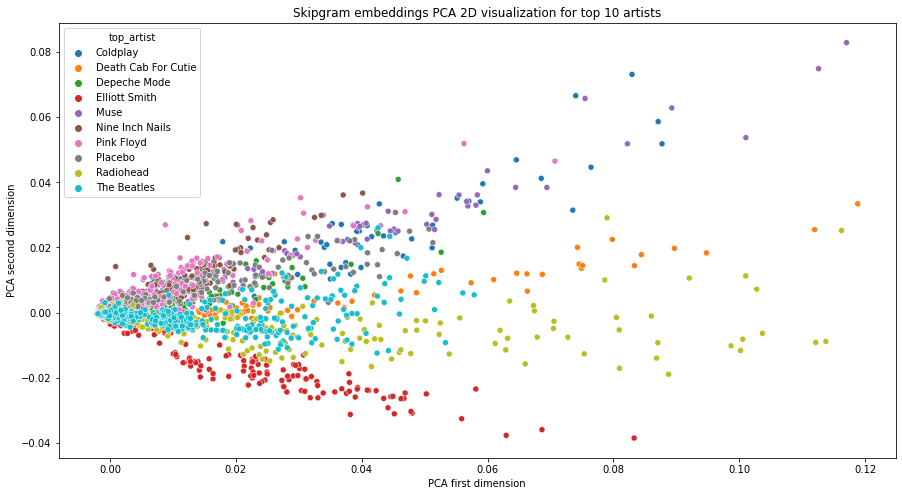

In [55]:
plot_embeddings_2D(tfidf_df_filtered, song_artists_values, 10)

# Classification Tasks

* Predict if two songs appear in the same context
* Predict if two songs are from the same artist
* Predict the artist of a song
* Predict the tag of a song

In [11]:
SEED = 42

In [12]:
def compute_metrics(y_test, y_pred, y_proba, multi=False):
    acc = accuracy_score(y_test, y_pred)
    if not multi:
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        return acc, f1, auc
    else:
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        return acc, f1, cm

In [13]:
def predict_RF(X_train, X_test, y_train, y_test, scoring='f1', multi=False,
               param_grid = {'n_estimators': [2,900, 1000, 1100],
                            'criterion': ['gini', 'entropy'],
                            'max_depth': [None, 5, 10, 100, 500],
                            'max_features': ['auto', 'sqrt', 'log2']
                            }):
    model = RandomForestClassifier(random_state=SEED)
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, verbose=3)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"Best parameters are: {grid.best_params_}")
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)


In [14]:
def predict_random(X_train, y_train, X_test, y_test, multi=False):
    random = DummyClassifier(strategy='uniform', random_state=SEED)
    random.fit(X_train, y_train)
    y_pred = random.predict(X_test)
    y_proba = random.predict_proba(X_test)[:, 1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)

def predict_majority(X_train, y_train, X_test, y_test, multi=False):
    majority = DummyClassifier(strategy='most_frequent', random_state=SEED)
    majority.fit(X_train, y_train)
    y_pred = majority.predict(X_test)
    y_proba = majority.predict_proba(X_test)[:, 1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)

In [15]:
def create_vectors_pairs(vectors, song_pairs):
    vector_pairs = vectors.merge(song_pairs, right_on="song1", left_index=True)\
            .merge(vectors, left_on="song2", right_index=True)\
            .drop(['song1', 'song2'], axis=1)
    print(len(vector_pairs))
    print(len(song_pairs))
    assert len(vector_pairs) == len(song_pairs)
    assert vector_pairs.shape[1] == vectors.shape[1] * 2
    return vector_pairs

## Same context classification

In [19]:
sorted_songs = songs.sort_values(["user_id", "timestamp"])

In [20]:
def pick_song_in_same_context(songs, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    np.random.seed(SEED)
    idx1 = np.random.randint(1, len(songs) - 1, half_n) #Exclude first and last song
    idx2 = idx1.copy() #Offset the first index by -1 or 1 
    idx2[::2] += 1
    idx2[1::2] -= 1
    songs1 = songs.iloc[idx1].song_id.values
    songs2 = songs.iloc[idx2].song_id.values
    X = np.c_[songs1, songs2]
    y = np.ones(half_n)
    return X, y
    
def pick_songs_in_diff_context(songs, half_n):
    songs1 = songs.sample(half_n, random_state=SEED).song_id.values
    songs2 = songs.sample(half_n, random_state=SEED + 1).song_id.values
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_context_dataset(sorted_songs, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    X_pos, y_pos = pick_song_in_same_context(sorted_songs, n//2)
    X_neg, y_neg = pick_songs_in_diff_context(sorted_songs, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [96]:
song_pairs, labels = create_context_dataset(sorted_songs, n= 10000)

In [97]:
#Only keep song with s2v embeddings
song_pairs = song_pairs.copy()
song_pairs['labels'] = labels
song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
labels = song_pairs.labels
song_pairs.drop('labels', axis=1, inplace=True)

### TF-IDF

In [98]:
tfidf_pairs = create_vectors_pairs(tfidf_df, song_pairs)

8485
8485


In [99]:
tfidf_pairs.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,982_y,983_y,984_y,985_y,986_y,987_y,988_y,989_y,990_y,991_y
1382,0.0,0.000000,0.0,0.009143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003974,0.0,0.0,0.002027,0.0,0.0,0.0,0.0,0.0,0.0
6851,0.0,0.000000,0.0,0.005735,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8584,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3106,0.0,0.000804,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9648,0.0,0.000790,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.5s
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.4s
[CV 5/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.4s
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.4min
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.2min
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.3min
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.2min
[CV 5/5] END criterion=gini, max_depth

[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   6.8s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   6.7s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   6.6s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   6.7s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   6.6s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=   7.4s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=   7.4s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=   7.5s
[CV 4/5] END criterio

[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=   5.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=   4.8s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=   4.5s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   6.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   6.8s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   6.6s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   5.5s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   5.9s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=   7.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=   6.4s
[CV

[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.5min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.6min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.5min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.3min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.4min
[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.4min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.4min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.4min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total tim

[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 1.9min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.1min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 1.9min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 1.9min
[CV 1/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 2.4min
[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 2.1min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 2.4min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 2.2min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 2.0min
[CV 1/5] END criterion=entropy, max_depth=None, max_fea

[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  14.8s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  15.5s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=   9.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=   7.7s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  11.3s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  10.2s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  10.4s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  15.1s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; total time=   0.6s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; tot

[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 2.2min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 2.5min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.3min
[CV 2/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.3min
[CV 3/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.1min
[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.3min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.1min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_es

[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.1min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.1min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.2min
[CV 2/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.3min
[CV 3/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.1min
[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.4min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.5min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=500, max_features=log2, n_es

In [101]:
print("TF-IDF:", acc, f1, auc)
print("Random:", predict_random(X_train, y_train, X_test, y_test))
print("Majority:",predict_majority(X_train, y_train, X_test, y_test))

TF-IDF: 0.4902769593400118 0.6541383446621352 0.48881905428760364
Random: (0.49616971125515613, 0.48955223880597015, 0.5)
Majority: (0.4926340601060695, 0.6600868535333597, 0.5)


### song2vec

In [102]:
s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

8485
8485


In [103]:
s2v_pairs.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
2416,0.080099,0.864616,0.471436,0.074726,1.148908,-0.630399,-0.530655,0.495115,-0.939442,0.538262,...,1.304962,-0.043532,-1.467525,-0.106839,-0.201679,-0.174556,-0.375344,-0.553966,-0.414131,-0.060302
3249,0.092656,1.021982,0.482486,0.162953,1.458531,-0.456922,-0.808088,0.469913,-1.109759,0.834617,...,1.304962,-0.043532,-1.467525,-0.106839,-0.201679,-0.174556,-0.375344,-0.553966,-0.414131,-0.060302
2532,0.080099,0.864616,0.471436,0.074726,1.148908,-0.630399,-0.530655,0.495115,-0.939442,0.538262,...,0.994198,-0.072898,-1.162338,-0.054488,-0.212095,-0.196816,-0.265199,-0.362052,-0.326012,-0.056850
1651,-0.023731,1.001483,0.474537,0.046131,1.076092,-0.592924,-0.783837,0.444142,-1.063470,0.717101,...,0.622503,-0.048610,-0.731744,-0.043423,-0.129149,-0.123916,-0.152679,-0.234185,-0.208944,-0.046655
4873,-0.023731,1.001483,0.474537,0.046131,1.076092,-0.592924,-0.783837,0.444142,-1.063470,0.717101,...,1.523960,-0.228382,-2.151627,0.289972,-0.400530,-0.138025,-0.379053,-0.788297,-0.606921,-0.089377


In [104]:
X_train, X_test, y_train, y_test = \
                train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.4min
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.3min
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.7min
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 1.4min
[CV 5/5] END criterion=gini, max_depth

[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  21.9s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  21.8s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  21.9s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  21.8s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  21.9s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=  24.3s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=  24.2s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=  24.3s
[CV 4/5] END criterio

[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=  21.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=  21.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=  21.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  23.3s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  23.9s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  24.4s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  23.3s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  23.4s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=  25.7s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=  26.2s
[CV

[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.5min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.4min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.5min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.4min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 1.5min
[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.6min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.6min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 1.6min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total tim

[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.6min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.7min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.7min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.7min
[CV 1/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 2.8min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 2.9min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 1/5] END criterion=entropy, max_depth=None, max_fea

[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  18.3s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  18.1s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  18.1s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  19.9s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  19.9s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  19.9s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  20.0s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  20.2s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; tot

[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 2/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.8min
[CV 3/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.9min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_es

[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.6min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.7min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.9min
[CV 2/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.8min
[CV 3/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.9min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=500, max_features=log2, n_es

In [105]:
print("Song2Vec:", acc, f1, auc)

Song2Vec: 0.5091337654684738 0.6042755344418052 0.5166852830524205


## Same artist classification

In [106]:
discography = songs[["artist_name", "track_name", "song_id"]].drop_duplicates()

In [66]:
def pick_songs_from_same_artist(discography, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    artist_with_multiple_songs = discography.groupby("artist_name")\
                                .agg(count=("track_name", "count")).reset_index()
    discography = discography.merge(artist_with_multiple_songs)
    
    song_pairs = discography.groupby("artist_name").agg(song1=("song_id", "first"), 
                                                        song2=("song_id", "last"))
    X = song_pairs.sample(half_n, random_state=SEED).values
    y = np.ones(half_n)
    return X, y
    
def pick_songs_from_diff_artist(discography, half_n):
    discography = discography.drop_duplicates("artist_name")
    random_songs = discography.sample(2*half_n, random_state=SEED).song_id.values
    songs1 = random_songs[:half_n]
    songs2 = random_songs[half_n:]
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_artist_dataset(discography, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    discography = discography.merge(s2v_df, left_on="song_id", right_index=True)
    discography = discography.merge(tfidf_df, left_on="song_id", right_index=True)
    X_pos, y_pos = pick_songs_from_same_artist(discography, n//2)
    X_neg, y_neg = pick_songs_from_diff_artist(discography, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [108]:
song_pairs, labels = create_artist_dataset(discography, 20000)

In [109]:
#Only keep song with s2v embeddings
song_pairs = song_pairs.copy()
song_pairs['labels'] = labels
song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
song_pairs = song_pairs[song_pairs.song1.isin(tfidf_df.index) & song_pairs.song2.isin(tfidf_df.index)]
labels = song_pairs.labels
# song_pairs.drop('labels', axis=1, inplace=True)

In [110]:
song_pairs_neg = song_pairs.query("labels == 0").iloc[:3547]
song_pairs_pos = song_pairs.query("labels == 1")

In [111]:
song_pairs = pd.concat([song_pairs_neg, song_pairs_pos])
labels = song_pairs.labels
song_pairs.drop('labels', axis=1, inplace=True)

### TF-IDF

In [112]:
tfidf_pairs = create_vectors_pairs(tfidf_df, song_pairs)

13547
13547


In [113]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)

In [114]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.6s
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.6s
[CV 5/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.5s
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 2.7min
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 2.5min
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 2.5min
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 2.5min
[CV 5/5] END criterion=gini, max_depth

[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   5.8s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   5.8s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   5.8s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   5.8s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=   5.9s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=   6.5s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=   6.5s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=   6.5s
[CV 4/5] END criterio

[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=   4.4s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=   4.4s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=   4.4s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   4.8s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   4.9s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   4.9s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   4.8s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=   5.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=   5.4s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=   5.3s
[CV

[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 2.9min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total tim

[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time=35.5min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.7min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 3.1min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 3.4min
[CV 1/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.4min
[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.6min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.2min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.6min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 4.4min
[CV 1/5] END criterion=entropy, max_depth=None, max_fea

[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=   4.5s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=   4.1s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=   4.9s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=   4.4s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=   4.9s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=   4.5s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=   5.0s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=   5.5s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; tot

[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 1.3min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 1.4min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 1.4min
[CV 2/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 1.6min
[CV 3/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 1.4min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_es

[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.6min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.6min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.8min
[CV 2/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.8min
[CV 3/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.8min
[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.8min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=500, max_features=log2, n_es

In [115]:
print("TF-IDF:", acc, f1, auc)

TF-IDF: 0.9394833948339484 0.9602520601066409 0.9374422682428871


### Song2vec

In [116]:
s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

13547
13547


In [117]:
X_train, X_test, y_train, y_test = \
                train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.4s
[CV 1/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 2.6min
[CV 2/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 3.0min
[CV 3/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 2.5min
[CV 4/5] END criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time= 2.5min
[CV 5/5] END criterion=gini, max_depth

[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=2; total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  54.3s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  58.4s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  50.3s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time= 1.2min
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=900; total time=  51.4s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=  54.2s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time=  49.9s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000; total time= 1.0min
[CV 4/5] END criterio

[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=  43.9s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=  45.6s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=900; total time=  59.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time= 1.2min
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  45.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  49.3s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  48.2s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1000; total time=  47.5s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=  50.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=1100; total time=  55.9s
[CV

[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 3.0min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 3.0min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 2.9min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 2.9min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1000; total time= 3.1min
[CV 1/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 3.4min
[CV 2/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 3.4min
[CV 3/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 3.3min
[CV 4/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total time= 3.2min
[CV 5/5] END criterion=gini, max_depth=500, max_features=auto, n_estimators=1100; total tim

[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.8min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.8min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.8min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time= 2.7min
[CV 1/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 2/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.1min
[CV 3/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 4/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.1min
[CV 5/5] END criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 1/5] END criterion=entropy, max_depth=None, max_fea

[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  27.9s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  27.8s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000; total time=  28.1s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  31.5s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  30.7s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  30.8s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  30.6s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=1100; total time=  30.8s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=2; tot

[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 2.8min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1000; total time= 2.7min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 2/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 3/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 3.1min
[CV 4/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 3.0min
[CV 5/5] END criterion=entropy, max_depth=100, max_features=auto, n_estimators=1100; total time= 2.9min
[CV 1/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.3s
[CV 3/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_es

[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.8min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1000; total time= 2.7min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 2/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 3.1min
[CV 3/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 4/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 3.0min
[CV 5/5] END criterion=entropy, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.9min
[CV 1/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=500, max_features=log2, n_estimators=2; total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=500, max_features=log2, n_es

In [118]:
print("Song2Vec:", acc, f1, auc)

Song2Vec: 0.8354243542435424 0.896327289632729 0.7904411176102482


In [119]:
print("Random:", predict_random(X_train, y_train, X_test, y_test))
print("Majority:",predict_majority(X_train, y_train, X_test, y_test))

Random: (0.5180811808118081, 0.6075721153846154, 0.5)
Majority: (0.733210332103321, 0.8460719608260592, 0.5)


## Top artists classification

In [22]:
#Load best song2vec for tasks
# kwargs_base = {'vector_size': 100, 'min_count': 5}
# sample2, emb_vectors2, model2 = get_embeddings(songs, **kwargs_base)
# model2.save("data/word2vec/base.model")
emb_vectors2, model2 = load_model("data/word2vec/base.model")

In [26]:
s2v_df2 = pd.DataFrame(data=emb_vectors2.values(), index=emb_vectors2.keys())

In [62]:
def create_top_artist_dataset(df, top_n=10):
    top_artist = df[df.song_id.isin(emb_vectors.keys())].artist_name.value_counts()\
        .to_frame().head(top_n).reset_index()['index']
    top_artist_codes = list(top_artist.cat.codes)
    top_artist = list(top_artist)
    top_df = songs[songs.artist_name.cat.codes.isin(top_artist_codes)].drop_duplicates('song_id').copy()
    mapping = {artist: top_artist.index(artist) for artist in top_artist}
    top_df['label'] = top_df.artist_name.map(mapping)
    top_df = top_df[['song_id', 'label']]
    top_df = top_df[top_df.song_id.isin(s2v_df.index) & top_df.song_id.isin(tfidf_df.index)]
    return top_df

In [71]:
top_artist_songs = create_top_artist_dataset(songs, top_n=30)
len(top_artist_songs)

In [32]:
param_grid = {'n_estimators': [1100], #2,900, 1000, 
            'criterion': ['gini'], #, 'entropy'
            'max_depth': [None, 5, 10, 100, 500],
            'max_features': ['auto', 'sqrt', 'log2'],
            'class_weight':['balanced']}
scorer = make_scorer(f1_score, average='weighted')

### TF-IDF

In [41]:
tfidf_top_artist = tfidf_df.merge(top_artist_songs, left_index=True, right_on='song_id')
assert len(top_artist_songs) == len(tfidf_top_artist)
X_tfidf = tfidf_top_artist.drop(['song_id', 'label'], axis=1)
y_tfidf = tfidf_top_artist.label.values.astype(int)

In [42]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_tfidf, y_tfidf, train_size=0.8, random_state=SEED)

acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer, multi=True)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=2; total time=   0.2s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time=  54.4s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=900; total time=  53.2s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=None, max_feature

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=900; total time=   5.9s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=900; total time=   5.9s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=900; total time=   5.8s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=900; total time=   5.8s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=1000; total time=   6.6s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=1000; total time=   6.5s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=1000; total time=   6.6s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=5, max_features=auto, n_estimators=1000; total time=   6.5s
[CV 5/5] END class_weight=ba

[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=1000; total time=  10.3s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=1100; total time=  11.6s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=1100; total time=  11.4s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=1100; total time=  11.5s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=1100; total time=  11.3s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=1100; total time=  11.3s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 3/5] END class_wei

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.2s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=2; total time=   0.1s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=900; total time=  35.5s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=900; total time=  35.3s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=900; total time=  35.4s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=100, max_features=sqrt, n_estimators=900; total time=  34.8s
[CV 5/5] END class_weigh

[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=900; total time=  45.4s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=900; total time=  44.0s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1000; total time=  49.5s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1000; total time=  49.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1000; total time=  49.6s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1000; total time=  48.7s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1000; total time=  49.4s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time=  55.1s
[CV 2/5] E

[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1000; total time=  54.6s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.0min
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.0min
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.0min
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time=  59.9s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=sqrt, n_estimators=1100; total time=  59.9s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=log2, n_estimators=2; total time=   0.2s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=None, max_features=log2, n_estimators=2; t

[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=2; total time=   0.1s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=2; total time=   0.1s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=2; total time=   0.1s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=900; total time=   5.0s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=900; total time=   4.9s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=900; total time=   5.0s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=900; total time=   5.1s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, n_estimators=900; total time=   4.9s
[CV 1/5] END c

[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=900; total time=   7.4s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=900; total time=   7.2s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=1000; total time=   8.1s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=1000; total time=   7.9s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=1000; total time=   8.1s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=1000; total time=   7.9s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=1000; total time=   7.9s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=log2, n_estimators=1100; total time=  

[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=100, max_features=log2, n_estimators=1000; total time=  27.9s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=100, max_features=log2, n_estimators=1100; total time=  31.3s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=100, max_features=log2, n_estimators=1100; total time=  31.2s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=100, max_features=log2, n_estimators=1100; total time=  31.2s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=100, max_features=log2, n_estimators=1100; total time=  31.1s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=100, max_features=log2, n_estimators=1100; total time=  30.7s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=500, max_features=auto, n_estimators=2; total time=   0.2s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=500, max_features=auto, n_estimators=2; total tim

[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=500, max_features=log2, n_estimators=1100; total time=  41.0s
Best parameters are: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 1100}


In [43]:
print("TF-IDF:", acc, f1)

TF-IDF: 0.8368336025848142 0.8363992755269931


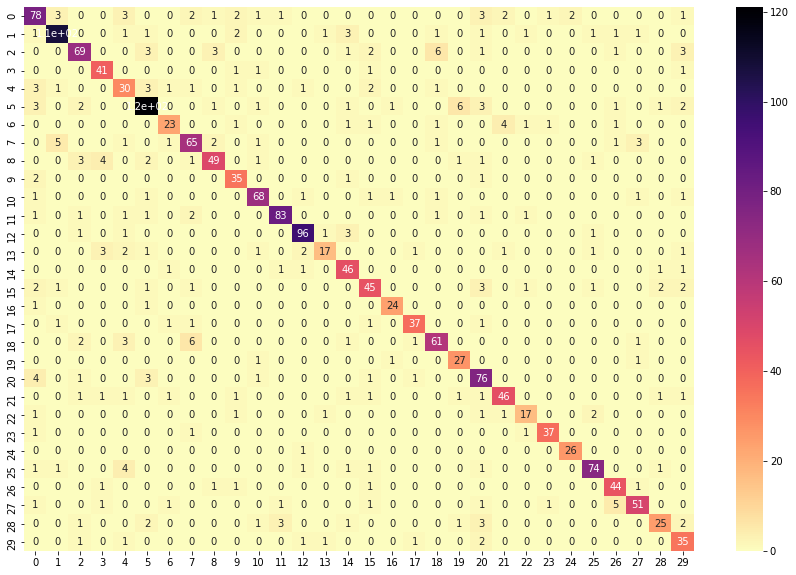

In [44]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

### Song2Vec

In [75]:
s2v_top_artist = s2v_df2.merge(top_artist_songs, left_index=True, right_on='song_id')
assert len(top_artist_songs) == len(s2v_top_artist)
X_s2v = s2v_top_artist.drop(['song_id', 'label'], axis=1)
y_s2v = s2v_top_artist.label.values.astype(int)

In [85]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_s2v, y_s2v, train_size=0.8, random_state=SEED)
acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer,multi=True)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.5min
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.5min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=No

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.8min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.7min
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.5min
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 2.2min
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time= 1.1min
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time= 1.1min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time= 1.1min
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time= 1.0min
[CV 5/5]

In [86]:
print("Song2Vec:", acc, f1)

Song2Vec: 0.7479806138933764 0.7618621429866351


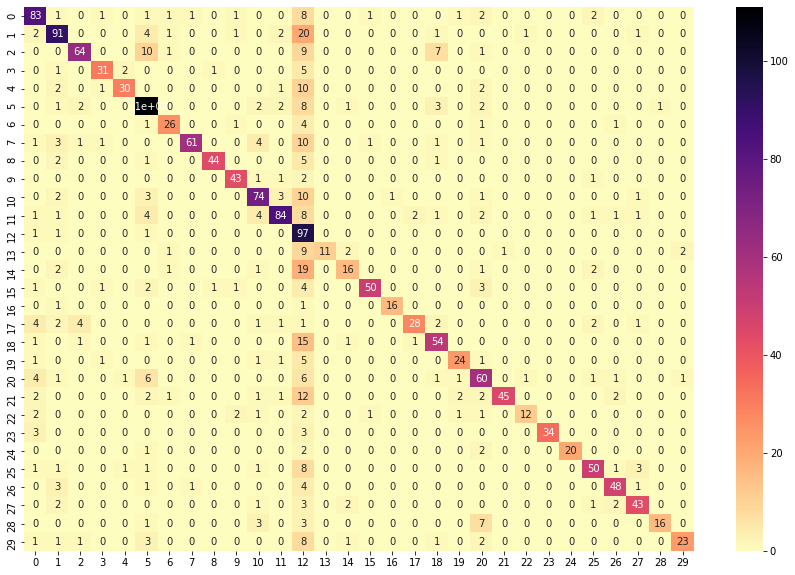

In [87]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

In [49]:
print("Random:", predict_random(X_train, y_train, X_test, y_test, multi=True)[:2])
print("Majority:",predict_majority(X_train, y_train, X_test, y_test, multi=True)[:2])

Random: (0.033925686591276254, 0.03561354992190356)
Majority: (0.07162089391491654, 0.00957344612129035)


## Top tag 

In [16]:
top_tags = pd.read_csv("data/song_tags_top1.csv")
songs = songs.merge(top_tags, how='left')

In [17]:
len(songs)

19098862

In [27]:
def create_top_tag_dataset(df, s2v_df, emb_vectors, tfidf_df, top_n=10):
    top_tags = list(df[df.song_id.isin(emb_vectors.keys())].tag_1.value_counts()\
        .to_frame().head(top_n).index)
    top_df = songs[songs.tag_1.isin(top_tags)].drop_duplicates('song_id').copy()
    mapping = {tag: top_tags.index(tag) for tag in top_tags}
    top_df['label'] = top_df.tag_1.map(mapping)
    top_df = top_df[['song_id', 'label']]
    top_df = top_df[top_df.song_id.isin(s2v_df.index) & top_df.song_id.isin(tfidf_df.index)]
    return top_df

In [28]:
top_tag_songs = create_top_tag_dataset(songs, s2v_df2, emb_vectors2, tfidf_df, top_n=10).iloc[:10000]
len(top_tag_songs)

10000

In [29]:
# param_grid = {'n_estimators': [2, 100, 200, 300],
#               'criterion': ['gini', 'entropy'],
#               'class_weight':['balanced']
#              }
# scorer = make_scorer(f1_score, average='weighted')

### TF-IDF

In [30]:
tfidf_top_tag = tfidf_df.merge(top_tag_songs, left_index=True, right_on='song_id')
assert len(top_tag_songs) == len(tfidf_top_tag)
X_tfidf = tfidf_top_tag.drop(['song_id', 'label'], axis=1)
y_tfidf = tfidf_top_tag.label.values.astype(int)

In [33]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_tfidf, y_tfidf, train_size=0.8, random_state=SEED)

acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer, multi=True)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.2min
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.5min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.3min
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.1min
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.1min
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, n_estimators=1100; total time=  54.1s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.1min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=No

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time=  52.2s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.0min
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.2min
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.2min
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  33.4s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  28.9s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  35.9s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  30.6s
[CV 5/5]

In [34]:
print("TF-IDF:", acc, f1)

TF-IDF: 0.7585 0.7477973866215656


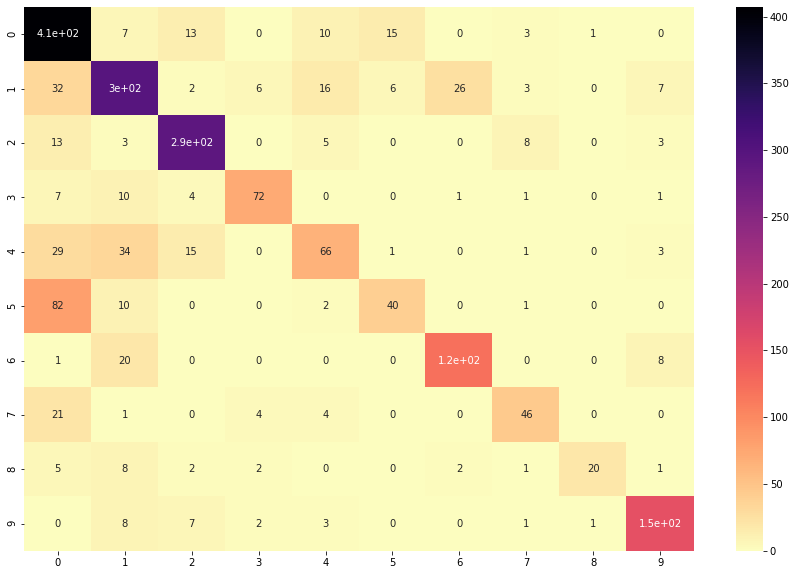

In [35]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

### Song2Vec

In [36]:
s2v_top_tag = s2v_df2.merge(top_tag_songs, left_index=True, right_on='song_id')
assert len(top_tag_songs) == len(s2v_top_tag)
X_s2v = s2v_top_tag.drop(['song_id', 'label'], axis=1)
y_s2v = s2v_top_tag.label.values.astype(int)

In [37]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_s2v, y_s2v, train_size=0.8, random_state=SEED)
acc, f1, cm = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer,multi=True)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.1min
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.1min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.2min
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 2.2min
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=auto, n_estimators=1100; total time= 1.2min
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.3min
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=None, max_features=sqrt, n_estimators=1100; total time= 1.2min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=No

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.2min
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.2min
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.2min
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=sqrt, n_estimators=1100; total time= 1.2min
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  46.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  45.8s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  47.4s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=500, max_features=log2, n_estimators=1100; total time=  50.2s
[CV 5/5]

In [38]:
print("Song2Vec:", acc, f1)

Song2Vec: 0.6315 0.6111785678359364


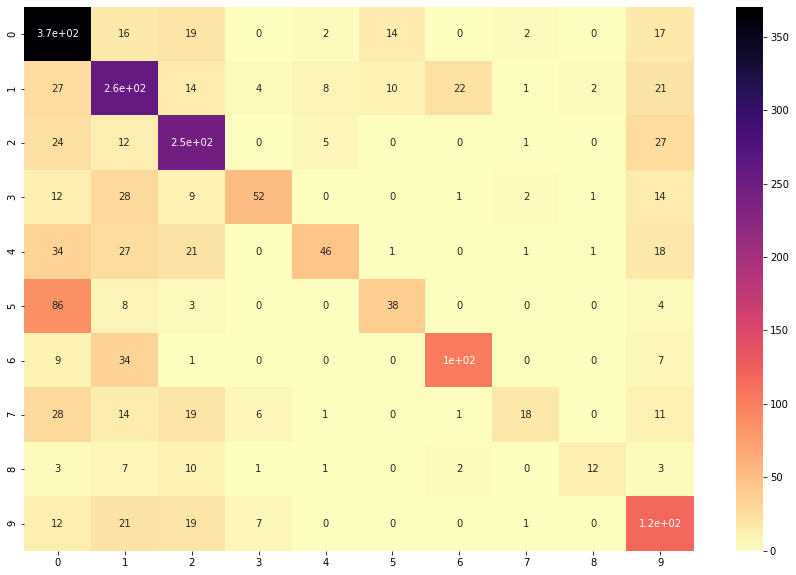

In [39]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

In [40]:
print("Random:", predict_random(X_train, y_train, X_test, y_test, multi=True)[:2])
print("Majority:",predict_majority(X_train, y_train, X_test, y_test, multi=True)[:2])

Random: (0.0965, 0.10629521826890108)
Majority: (0.22, 0.07934426229508197)
